# Food segmentation with a U-Net-like architecture

**Description:** Food segmentation model trained from scratch on coco dataset.

In [2]:
!git clone https://github.com/gmurro/FoodRecognition.git

Cloning into 'FoodRecognition'...
remote: Enumerating objects: 76312, done.
remote: Counting objects: 100% (50808/50808), done.
remote: Compressing objects: 100% (27368/27368), done.
remote: Total 76312 (delta 23486), reused 50759 (delta 23439), pack-reused 25504
Receiving objects: 100% (76312/76312), 1.31 GiB | 23.75 MiB/s, done.
Resolving deltas: 100% (23522/23522), done.
Checking out files: 100% (52101/52101), done.


In [3]:
%cd /content/FoodRecognition/src

/content/FoodRecognition/src


Auxiliary function to plot images

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_im(img_path, img=None):
  """
  Auxiliary function to plot images. 

  Parameters
  ----------
  img_path : str
      The file location from which read the image. It is ignored if you pass img.
  img : np.array, optional
      If you have a np.array object in a form of image, you can pass it direcly.
  """

  fig = plt.figsize=(10,)

  # read image from the defined path if img it is available
  if img is None:
    img = mpimg.imread(img_path)

  plt.imshow(img)
  plt.axis('off')
  plt.show()

In [2]:
import matplotlib.patches as mpatches
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

def show_multiple_im(input_img_paths, target_img_paths, class_names, predictions=None, figsize=(10,10)):
  """
  Auxiliary function to plot a batch of images. 

  Parameters
  ----------
  input_img_paths : str
      The file locations from which read the input images.
  target_img_paths : str
      The file locations from which read the masks.
  predictions : np.array, optional
      Batch of predictions.
  figsize :  array
      Size of the figure to plot.
  """

  n_images = len(input_img_paths)

  # plot 3 or 2 columns if predictions is available or not
  ncols = 2 if predictions is None else 3

  fig, axes = plt.subplots(figsize=figsize, nrows=n_images, ncols=ncols)

  for i, (input_img_path, target_img_path) in enumerate(zip(input_img_paths, target_img_paths)):
    img = mpimg.imread(input_img_path)
    ax = axes[i,0] if n_images > 1 else axes[0]
    ax.imshow(img)
    ax.axis('off')
        
    mask = img_to_array(load_img(target_img_path, color_mode="grayscale"))
    ax = axes[i,1] if n_images > 1 else axes[1]
    im = ax.imshow(mask[:,:,0])
    ax.axis('off')
    
    values = np.array(np.unique(mask), dtype=np.uint8)
    colors = [ im.cmap(im.norm(value)) for value in range(len(class_names))]
    patches = [ mpatches.Patch(color=colors[i], label=class_names[i] ) for i in values ]
    ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    

    if predictions is not None:
        ax = axes[i,2] if n_images > 1 else axes[2]
        ax.imshow(predictions[i])
        ax.axis('off')
        
        values = np.array(np.unique(predictions[i]), dtype=np.uint8)
        colors = [ im.cmap(im.norm(value)) for value in range(len(class_names))]
        patches = [ mpatches.Patch(color=colors[i], label=class_names[i] ) for i in values ]
        ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

  # set column title
  col_titles = ['Input', 'Target', 'Predictions']
  if n_images > 1:
    for ax, col in zip(axes[0], col_titles):
      ax.set_title(col)
  else:
    for ax, col in zip(axes, col_titles):
      ax.set_title(col)

  fig.tight_layout()
  plt.show()

## Prepare paths of input images and target segmentation masks

In [44]:
img_size = (192, 192)

class_names = ['background','banana','broccoli','egg','milk','beer']
#class_names = ['background','food']

num_classes = len(class_names)
batch_size = 32

In [45]:
import os

# prepare data for training 

input_train_dir = "../data/subset/train/images/"
masks_train_dir = "../data/subset/train/masks/"

input_train_paths = sorted(
    [
        os.path.join(input_train_dir, fname)
        for fname in os.listdir(input_train_dir)
        if fname.endswith(".jpg")
    ]
)

target_train_paths = sorted(
    [
        os.path.join(masks_train_dir, fname)
        for fname in os.listdir(masks_train_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)


for input_path, target_path in zip(input_train_paths[:5], target_train_paths[:5]):
    print(input_path, "|", target_path)

n_train_sample = len(input_train_paths)
print("Number of training samples:", n_train_sample)

../data/subset/train/images/006446.jpg | ../data/subset/train/masks/006446.png
../data/subset/train/images/006489.jpg | ../data/subset/train/masks/006489.png
../data/subset/train/images/006498.jpg | ../data/subset/train/masks/006498.png
../data/subset/train/images/006511.jpg | ../data/subset/train/masks/006511.png
../data/subset/train/images/006572.jpg | ../data/subset/train/masks/006572.png
Number of training samples: 1546


In [46]:
# prepare data for validation 

input_val_dir = "../data/subset/val/images/"
masks_val_dir = "../data/subset/val/masks/"


input_val_paths = sorted(
    [
        os.path.join(input_val_dir, fname)
        for fname in os.listdir(input_val_dir)
        if fname.endswith(".jpg")
    ]
)

target_val_paths = sorted(
    [
        os.path.join(masks_val_dir, fname)
        for fname in os.listdir(masks_val_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)


for input_path, target_path in zip(input_val_paths[:5], target_val_paths[:5]):
    print(input_path, "|", target_path)

n_val_sample = len(input_val_paths)
print("Number of validation samples:", n_val_sample)

../data/subset/val/images/006844.jpg | ../data/subset/val/masks/006844.png
../data/subset/val/images/008964.jpg | ../data/subset/val/masks/008964.png
../data/subset/val/images/009513.jpg | ../data/subset/val/masks/009513.png
../data/subset/val/images/009624.jpg | ../data/subset/val/masks/009624.png
../data/subset/val/images/010090.jpg | ../data/subset/val/masks/010090.png
Number of validation samples: 81


## What does one input image and corresponding segmentation mask look like?

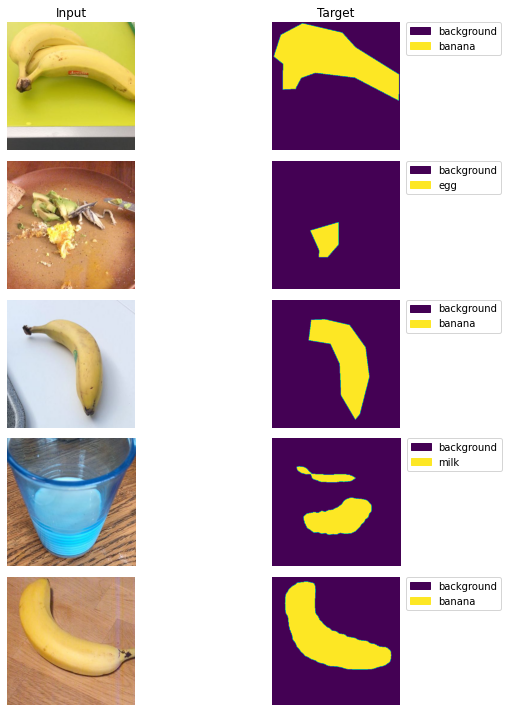

In [47]:
import PIL
from PIL import ImageOps
import numpy as np

# Display 3 input images and their mask
n = 5

imgs = input_train_paths[0:n]
masks = target_train_paths[0:n]

# show images
show_multiple_im(imgs, masks, class_names)

In [48]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array


class FoodRecognition(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
           
        return x, y

In [49]:
from tqdm.notebook import tqdm
from keras.utils import to_categorical

def load_images(input_img_paths, img_size):
    x = np.zeros((len(input_img_paths),) + img_size + (3,), dtype="float32")
    
    print("Loading images:")
    pbar = tqdm(total=len(input_img_paths))
        
    for j, path in enumerate(input_img_paths):
        img = img_to_array(load_img(path, target_size=img_size))
        x[j] = img
        
        pbar.update(1)
        
    return x

def load_masks(target_img_paths, img_size, num_classes):
    paths = list()
    y = np.zeros((len(target_img_paths),) + img_size + (num_classes,), dtype="float32")
    
    print("Loading masks:")
    pbar = tqdm(total=len(target_img_paths))
    
    for j, path in enumerate(target_img_paths):
        img = img_to_array(load_img(path, target_size=img_size, color_mode="grayscale"))
        img = to_categorical(img, num_classes=num_classes)

        y[j] = img
        pbar.update(1)
        
    return y

Eff U-net

In [60]:
from tensorflow.keras.layers import *
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_efficientnetb5_unet(input_shape, n_classes=1):
    """ Input """
    inputs = Input(input_shape, name="input_1")

    """ Pre-trained EfficientNetB5 Model """
    efficientnetb5 = EfficientNetB5(include_top=False, weights="imagenet", input_tensor=inputs)
    for layer in efficientnetb5.layers:
        layer.trainable = False

    """ Encoder """
    s1 = efficientnetb5.get_layer("block2a_expand_activation").input
    s2 = efficientnetb5.get_layer("block3a_expand_activation").output
    s3 = efficientnetb5.get_layer("block4a_expand_activation").output
    s4 = efficientnetb5.get_layer("block6a_expand_activation").output

    """ Bridge """
    b1 = efficientnetb5.get_layer("top_activation").output

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Last Upsampler """
    x = Conv2DTranspose(32, (2, 2), strides=2, padding="same")(d4)
    x = conv_block(x, 32)

    """ Output """
    outputs = Conv2D(n_classes, (1,1), padding="same", activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs, name="EfficientNetB5_U-Net")
    return model

# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

# Build model
model = build_efficientnetb5_unet(img_size+ (3,), num_classes)
model.summary()

Model: "EfficientNetB5_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 192, 192, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 192, 192, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 193, 193, 3)  0           normalization[0][0]              
_______________________________________________________________________________

In [50]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras import layers
input = layers.Input(shape=img_size + (3,), name='image_input')
# s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) # Normalization

""" Pre-trained EfficientNetB5 Model """
b5 = EfficientNetB5(include_top=True, weights="imagenet", input_tensor=input)

In [26]:
b5.get_layer("block3e_drop").output

<KerasTensor: shape=(None, 20, 20, 64) dtype=float32 (created by layer 'block3e_drop')>

In [51]:
b5.summary()

Model: "efficientnetb5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 192, 192, 3)  0           image_input[0][0]                
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 192, 192, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 193, 193, 3)  0           normalization_1[0][0]            
_____________________________________________________________________________________

In [65]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB5

def conv_block(input, num_filters, size=3, padding='same', initializer="he_normal"):
    x = layers.Conv2D(filters=num_filters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(filters=num_filters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x


def deconv_block(input, num_filters, skip_features, size=2, padding='same', strides=(2, 2)):
    x = layers.Conv2DTranspose(num_filters, kernel_size=(size, size), strides=strides, padding=padding)(input)
    x = layers.concatenate([x, skip_features], axis=3)
    x = conv_block(x, num_filters)
    return x

def eff_unet(img_size, num_classes):
    
    ''' Input layer '''
    input_layer = layers.Input(shape=img_size + (3,), name='image_input')
    # s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) # Normalization
    
    """ Pre-trained EfficientNetB5 Model """
    efficientnetb5 = EfficientNetB5(include_top=False, weights="imagenet", input_tensor=input_layer)
    for layer in efficientnetb5.layers:
        layer.trainable = False
    
    """ Encoder """
    s1 = efficientnetb5.get_layer("block2a_expand_activation").input
    s2 = efficientnetb5.get_layer("block3a_expand_activation").output
    s3 = efficientnetb5.get_layer("block4a_expand_activation").output
    s4 = efficientnetb5.get_layer("block6a_expand_activation").output

    """ Bridge """
    b1 = efficientnetb5.get_layer("top_activation").output
    
    """ Decoder """
    d1 = deconv_block(input=b1, num_filters=512, skip_features=s4)
    d2 = deconv_block(input=d1, num_filters=256, skip_features=s3)
    d3 = deconv_block(input=d2, num_filters=128, skip_features=s2)
    d4 = deconv_block(input=d3, num_filters=64,  skip_features=s1)

    """ Last Upsampler """
    x = Conv2DTranspose(32, (2, 2), strides=2, padding="same")(d4)
    x = conv_block(x, 32)

    """ Output """
    # output: add a per-pixel classification layer
    output_layer = layers.Conv2D(filters=num_classes, kernel_size=(1, 1), activation="sigmoid", padding="same")(x)

    # Define the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='EfficientNetB5_U-Net')
    return model
    

# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

# Build model
model = eff_unet(img_size, num_classes)
model.summary()

Model: "EfficientNetB5_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 192, 192, 3)  0           image_input[0][0]                
__________________________________________________________________________________________________
normalization (Normalization)   (None, 192, 192, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 193, 193, 3)  0           normalization[0][0]              
_______________________________________________________________________________

Prepare U-Net Xception-style model like in this [guide](https://keras.io/examples/vision/oxford_pets_image_segmentation/)


In [9]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, dpi=60)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [66]:
# load data
x_train = load_images(input_train_paths, img_size)
y_train = load_masks(target_train_paths, img_size, num_classes)

x_val = load_images(input_val_paths, img_size)
y_val = load_masks(target_val_paths, img_size, num_classes)

Loading images:


  0%|          | 0/1546 [00:00<?, ?it/s]

Loading masks:


  0%|          | 0/1546 [00:00<?, ?it/s]

Loading images:


  0%|          | 0/81 [00:00<?, ?it/s]

Loading masks:


  0%|          | 0/81 [00:00<?, ?it/s]

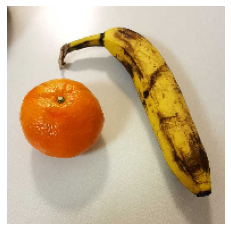

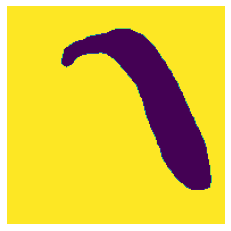

The values in the mask are: [0. 1.]


In [67]:
# print random image from dataset
import random

i = random.randint(0,batch_size)
img = x_val[i,:,:,:]/255
mask = y_val[i,:,:,0]

show_im("", img)
show_im("", mask)

print("The values in the mask are: {}".format(np.unique(mask)))

In [68]:
%env SM_FRAMEWORK = tf.keras
import segmentation_models as sm

#loss = sm.losses.DiceLoss(per_image=True, class_weights=class_weights) + sm.losses.BinaryFocalLoss() + sm.losses.JaccardLoss(per_image=True, class_weights=class_weights)
#TODO ADD CLASS WEIGHTS

loss = sm.losses.BinaryFocalLoss() + sm.losses.DiceLoss()

threshold = 0.5

metrics = [sm.metrics.IOUScore(threshold=threshold, per_image=True)
           , sm.metrics.Precision(threshold=threshold, per_image=True)
           , sm.metrics.Recall(threshold=threshold, per_image=True)
           , sm.metrics.FScore(threshold=threshold, per_image=True)]

model.compile(optimizer="adam", loss=loss, metrics=metrics)

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [14]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

In [69]:
import datetime
cp_file_name = "model/food_segmentation_subset_focal.h5"

callbacks = [
    #Model checkpoint save weights ad other informations
    keras.callbacks.ModelCheckpoint(cp_file_name, save_best_only=True)
    , keras.callbacks.TensorBoard(log_dir="model/logs/tensorboard_logs_"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
]

# Train the model, doing validation at the end of each epoch.
epochs = 10
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), callbacks=callbacks)

Epoch 1/10


ResourceExhaustedError:  OOM when allocating tensor with shape[32,208,96,96] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node EfficientNetB5_U-Net/concatenate_3/concat (defined at <ipython-input-69-222ca88873db>:12) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_248957]

Function call stack:
train_function


In [49]:
%load_ext tensorboard
%tensorboard --logdir model/logs/tensorboard_logs_20210531-155753

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 8096.

In [38]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

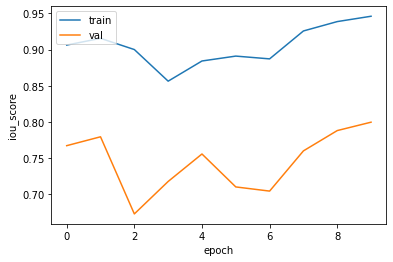

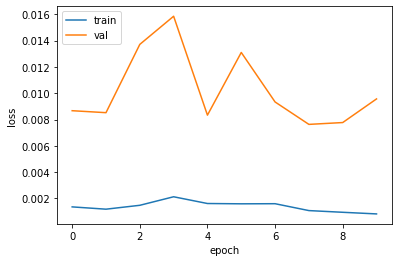

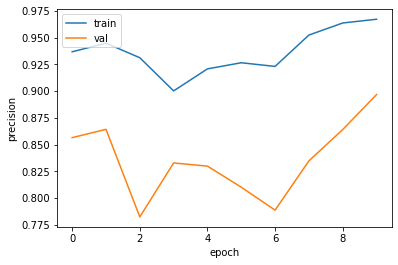

In [46]:
plot_history(history,['iou_score','val_iou_score'])
plot_history(history,['loss','val_loss'])
plot_history(history,['precision','val_precision'])

In [15]:
# if you have pretrained weights, load them here
model.load_weights('model/food_segmentation_subset_focal.h5')

In [16]:
val_gen = FoodRecognition(batch_size, img_size, input_val_paths, target_val_paths)
val_preds = model.predict(val_gen)

In [21]:
def display_mask(i, size=img_size):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    img = img.resize(size)
    display(img)
    print(img.size)

def get_pred_mask(pred):
   mask = np.argmax(pred, axis=-1)
   return mask

def binarize(pred, thresold):
   return np.where(pred > thresold, 1, 0)

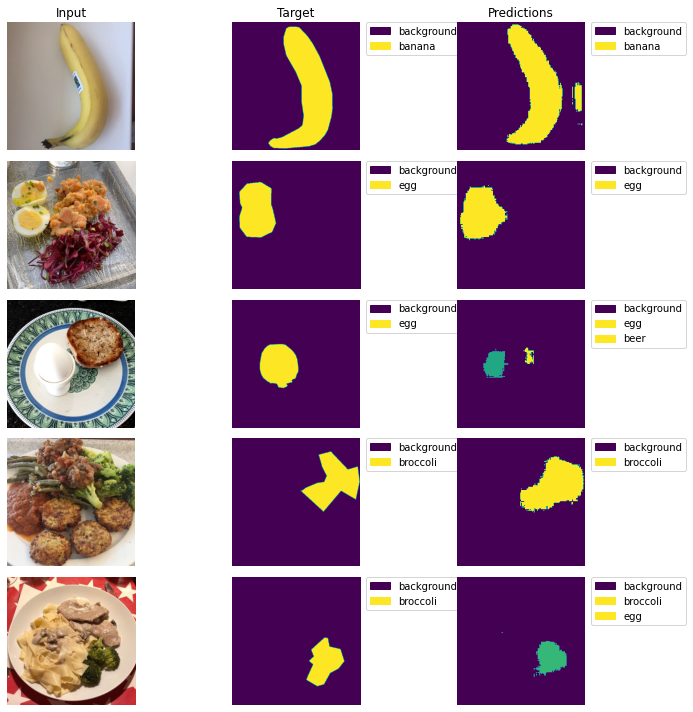

In [18]:
# Display 5 random predictions
n = 5
np.random.seed(4)
idx = np.random.choice(range(len(val_preds)), n)

imgs = [input_val_paths[i] for i in idx]
masks = [target_val_paths[i] for i in idx]
predicions = [get_pred_mask(val_preds[i]) for i in idx]

show_multiple_im(imgs, masks, class_names, predicions)

In [19]:
def show_mask(img, mask, labels, alpha=0.6, figsize=(5,5)):
    """
    Auxiliary function to plot images with mask overlapped.

    Parameters
    ----------
    img : np.array
        Image to plot as background
    mask : np.array
        Mask to plot as foreground
    labels : list
        List of categories containing also the background category.
        Its size must be equal to the number of channels in the mask
    alpha : double, optional
        Transparency of the mask. Default is 0.6
    figsize : pair, optional
        Size of the figure to plot
    """
    plt.figure(figsize=figsize)

    # Preparing the mask with overlapping
    mask_plot = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float32)
    for i in range(len(labels)):
        mask_plot += mask[:, :, i] * i
        mask_plot[mask_plot >= i] = i
    values = np.array(np.unique(mask_plot), dtype=np.uint8)

    # plot image as background
    plt.imshow(img)

    # plot foreground mask
    im = plt.imshow(mask_plot, interpolation='none', alpha=alpha)

    # legend for mask colors
    colors = [im.cmap(im.norm(value)) for value in range(len(labels))]
    patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in values]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.axis('off')
    plt.show()

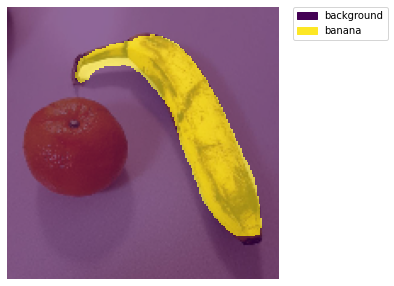

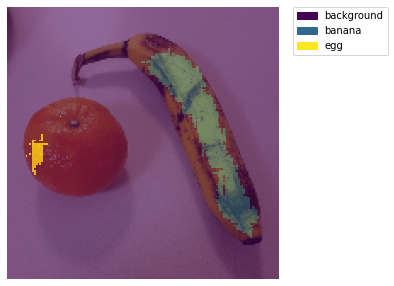

IOU 0.8992379


In [57]:
from keras.preprocessing.image import img_to_array
img = img_to_array(load_img(input_val_paths[2], target_size=img_size))/255
gt = to_categorical(img_to_array(load_img(target_val_paths[2], target_size=img_size,  color_mode="grayscale")), num_classes=num_classes)
pred = binarize(val_preds[2], 0.5)

show_mask(img, gt, class_names)
show_mask(img, pred, class_names)




In [1]:
# COMPARE IMPLEMENTATIONS OF IOU METRIC

# gt and pred only fron channel banana
gt_b = gt[:,:,1]
pred_b = pred[:,:,1]
pred_raw = val_preds[2,:,:,1] #not binarized


m = keras.metrics.MeanIoU(num_classes=num_classes)
m.update_state(gt_b, pred_b)
print("IOU",m.result().numpy())

%env SM_FRAMEWORK = tf.keras
import segmentation_models as sm
m1 = sm.metrics.IOUScore(per_image=True, class_weights=[0.1, 0.6, 0.1, 0.05, 0.05, 0.1], threshold=0.5)
print("IOU",m1.__call__(gt, val_preds[2])) # not binarized

NameError: name 'gt' is not defined